In [4]:
from PIL import Image
import tensorflow as tf
import os
import numpy as np
import matplotlib.pyplot as plt
from sklearn.utils import shuffle
from time import time
import pickle as pk
%matplotlib inline

In [5]:
%run "../data/archive/translate.py"
pk.dump(translate, open("../translate.pk", "wb"))

In [18]:
batch_size = 64
img_height = 100
img_width = 100
data_root='../data/archive/raw-img/'
print("datos de entrenamiento")
data_train = tf.keras.preprocessing.image_dataset_from_directory(str(data_root),
                                                               validation_split=0.2,
                                                               subset="training",
                                                               seed=123,
                                                               image_size=(img_height, img_width),
                                                               batch_size=batch_size,
                                                               label_mode='categorical')

print("datos de validación")
data_test = tf.keras.preprocessing.image_dataset_from_directory(str(data_root),
                                                               validation_split=0.2,
                                                               subset="validation",
                                                               seed=123,
                                                               image_size=(img_height, img_width),
                                                               batch_size=batch_size,
                                                               label_mode='categorical')

datos de entrenamiento
Found 30349 files belonging to 11 classes.
Using 3035 files for training.
datos de validación
Found 30349 files belonging to 11 classes.
Using 3034 files for validation.


In [19]:
class_names = np.array(data_train.class_names)
print(class_names)

['cane' 'cavallo' 'elefante' 'farfalla' 'gallina' 'gatto' 'mucca' 'pecora'
 'ragno' 'scoiattolo' 'traffic_signals']


In [20]:
tl_model = tf.keras.applications.VGG16(weights="imagenet", include_top=False,
                                       input_shape=(img_height,img_width,3))

In [21]:
tl_model._name = "deep_model"
tl_model.summary()

Model: "deep_model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 100, 100, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 100, 100, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 100, 100, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 50, 50, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 50, 50, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 50, 50, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 25, 25, 128)       0

- Note que en los notebooks pasados se utilizó el algoritmo de transfer learning con los pesos configurados para ser entrenados.
- Ahora, configuraremos la variable <b>trainable</b> como False para que los pesos del modelo pre-entrenado no se actualicen.

In [22]:
for l in tl_model.layers:
    l.trainable = False

In [23]:
tl_model.summary()

Model: "deep_model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 100, 100, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 100, 100, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 100, 100, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 50, 50, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 50, 50, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 50, 50, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 25, 25, 128)       0

In [24]:
model = tf.keras.models.Sequential()
model.add(tf.keras.layers.experimental.preprocessing.Rescaling(1./255, input_shape=(img_height, img_width, 3)))
model.add(tl_model)
model.add(tf.keras.layers.Flatten())
model.add(tf.keras.layers.Dropout(.1))
model.add(tf.keras.layers.Dense(1024, activation="relu"))
model.add(tf.keras.layers.Dropout(.15))
model.add(tf.keras.layers.Dense(1024, activation="relu"))
model.add(tf.keras.layers.Dropout(.15))
model.add(tf.keras.layers.Dense(len(class_names), activation="softmax"))

model.compile(loss='categorical_crossentropy', optimizer=tf.keras.optimizers.SGD(lr=1e-3, momentum=0.9),
              metrics = ['accuracy'])

In [25]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
rescaling_1 (Rescaling)      (None, 100, 100, 3)       0         
_________________________________________________________________
deep_model (Functional)      (None, 3, 3, 512)         14714688  
_________________________________________________________________
flatten_1 (Flatten)          (None, 4608)              0         
_________________________________________________________________
dropout_3 (Dropout)          (None, 4608)              0         
_________________________________________________________________
dense_3 (Dense)              (None, 1024)              4719616   
_________________________________________________________________
dropout_4 (Dropout)          (None, 1024)              0         
_________________________________________________________________
dense_4 (Dense)              (None, 1024)             

In [26]:
hist = model.fit(data_train, epochs=3, validation_data=data_test)

Epoch 1/3
48/48 [==============================] - 326s 7s/step - loss: 2.2959 - accuracy: 0.2361 - val_loss: 1.6284 - val_accuracy: 0.5185
Epoch 2/3
48/48 [==============================] - 299s 6s/step - loss: 1.6153 - accuracy: 0.4929 - val_loss: 1.3823 - val_accuracy: 0.5649
Epoch 3/3
48/48 [==============================] - 295s 6s/step - loss: 1.4300 - accuracy: 0.5301 - val_loss: 1.1996 - val_accuracy: 0.6084


In [27]:
model.save("../model_test/")

INFO:tensorflow:Assets written to: ../model_test/assets


In [28]:
model = tf.keras.models.load_model("../model_test/")

predicción: elephant


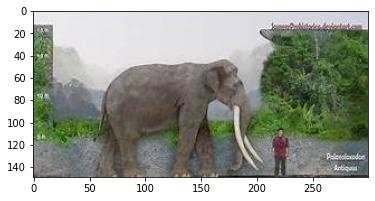

In [29]:
from prediction import cnn_images_10

cnn = cnn_images_10(ruta_modelo="../models/", ruta_translate="../translate.pk",
                   ruta_class="../class_name.pk")

ruta_imagen = "../data/archive/raw-img/elefante/OIP-u5FgbAEhiROUL92boj53DQHaDr.jpeg"
plt.imshow(Image.open(ruta_imagen))
print("predicción:", cnn.predict(ruta_imagen))

In [30]:
#predecimos en el conjunto de validación
y_test = np.array([])
y_test_predict = np.array([])
for x, y in data_test:
    y_test_predict = np.concatenate((y_test_predict, np.argmax(model.predict(x), axis=1)))
    y_test = np.concatenate((y_test, np.argmax(y, axis=1)))

In [31]:
#predecimos en el conjunto de entrenamiento
y_train = np.array([])
y_train_predict = np.array([])
for x, y in data_train:
    y_train_predict = np.concatenate((y_train_predict, np.argmax(model.predict(x), axis=1)))
    y_train = np.concatenate((y_train, np.argmax(y, axis=1)))

In [32]:
print("precisión en los datos de entrenamiento:")
for i in np.unique(y_train):
    print("{:16}:{}%".format(class_names[int(i)],np.round(sum((y_train==i)*(y_train_predict==i))/(sum(y_train==i))*100, 2)))
print()
print("precisión en los datos de prueba:")
for i in np.unique(y_test):
    print("{:16}:{}%".format(class_names[int(i)],np.round(sum((y_test==i)*(y_test_predict==i))/(sum(y_test==i))*100, 2)))

precisión en los datos de entrenamiento:
cane            :74.57%
cavallo         :77.54%
elefante        :12.5%
farfalla        :63.13%
gallina         :60.2%
gatto           :13.29%
mucca           :2.17%
pecora          :5.29%
ragno           :91.58%
scoiattolo      :43.37%
traffic_signals :99.51%

precisión en los datos de prueba:
cane            :76.02%
cavallo         :74.23%
elefante        :10.37%
farfalla        :55.66%
gallina         :58.3%
gatto           :12.5%
mucca           :0.54%
pecora          :4.66%
ragno           :91.2%
scoiattolo      :41.24%
traffic_signals :99.29%


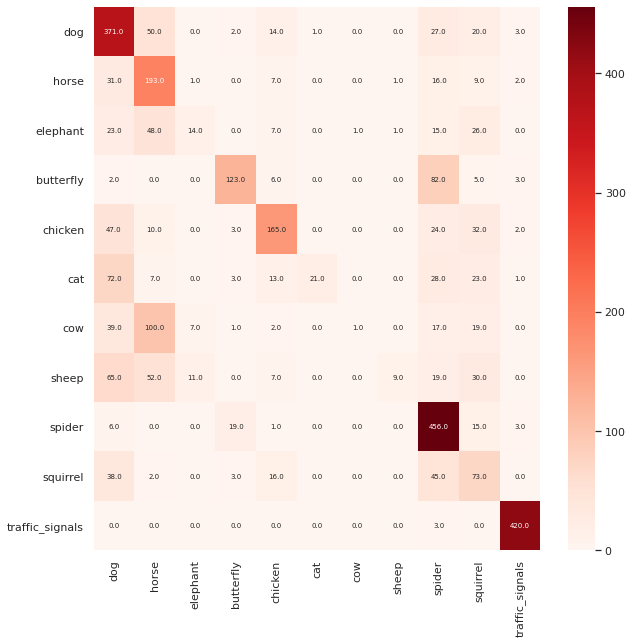

In [52]:
from sklearn.metrics import confusion_matrix
import pandas as pd
import seaborn as sn

cm = confusion_matrix(y_test, y_test_predict)
labels = [cnn.translate[i] for i in class_names]
if len(labels) != 0:
    df_cm = pd.DataFrame(cm, labels, labels)
else:
    num_label = len(np.unique(labels_test))
    df_cm = pd.DataFrame(self.cm, range(num_label), range(num_label))
    
plt.figure(figsize=(10,10))
sn.set(font_scale=1) # for label size
g = sn.heatmap(df_cm, annot=True, annot_kws={"size": 7}, cmap = plt.cm.Reds, fmt=".1f") # font size
plt.yticks(rotation=0)
plt.show() 

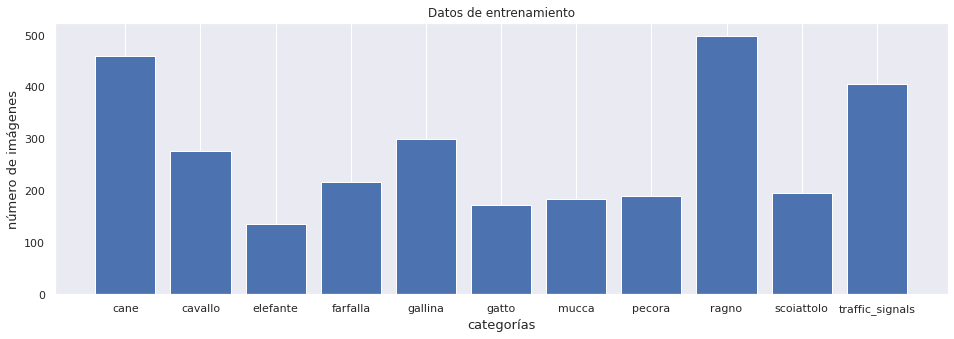

In [40]:
hist_train = []
for val in np.unique(y_train):
    hist_train.append(sum(y_train == val))
    
plt.figure(figsize=(16,5))
plt.title("Datos de entrenamiento")
plt.bar(np.unique(y_train), hist_train)
plt.grid(axis="y")
plt.ylabel("número de imágenes", fontsize=13)
plt.xlabel("categorías", fontsize=13)
plt.xticks(np.unique(y_train), np.unique(class_names));

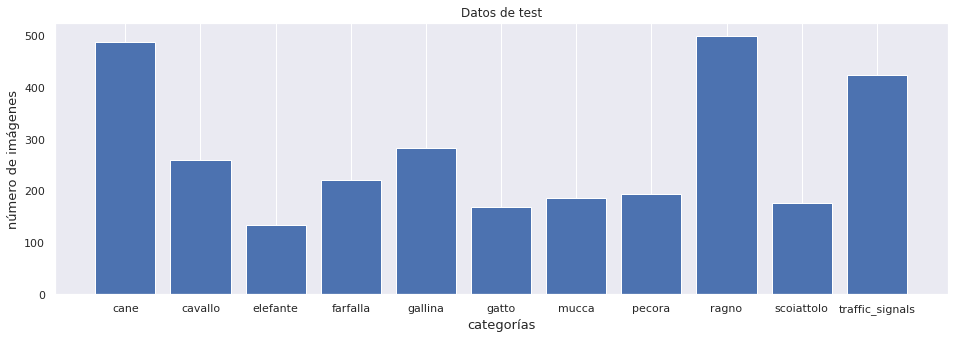

In [42]:
hist_test = []
for val in np.unique(y_test):
    hist_test.append(sum(y_test == val))
    
plt.figure(figsize=(16,5))
plt.title("Datos de test")
plt.bar(np.unique(y_test), hist_test)
plt.grid(axis="y")
plt.ylabel("número de imágenes", fontsize=13)
plt.xlabel("categorías", fontsize=13)
plt.xticks(np.unique(y_test), np.unique(class_names));